# Questão 1°) - Processos

### Importações

In [ ]:
import io
import pprint
import pandas as pd
import numpy as np
import statistics
import random
import copy
import matplotlib.pyplot as plt
import hashlib
import colorsys
import matplotlib.colors as mcolors
import json
import io
from google.colab import files

## Área de upload

In [2]:
print('\x1b[1;31m'+'Adicione um JSON'+'\x1b[0m')
data = files.upload()

file_content = list(data.values())[0]
data_dict = json.loads(file_content.decode('utf-8'))

Adicione um JSON


Saving so.json to so.json


## Extraindo dados do Json


In [3]:
context_switch_cost = data_dict['metadata']['context_switch_cost']
throughput_window_T = data_dict['metadata']['throughput_window_T']
rr_quantums = data_dict['metadata']['rr_quantums']
processes = data_dict['workload']['processes']

## Funções Auxiliares

In [4]:
# Retorna o tempo de chegada de um processo
def get_chegada(processo):
  return processo['arrival_time']

# Retorna o tempo de execução (burst) de um processo
def get_tempo_execucao(processo):
  return processo['burst_time']

# Gera um dicionário {pid: cor}, atribuindo uma cor para cada processo
def gerar_cores(processos):
    n = len(processos)
    pid_to_color = {}
    for i, p in enumerate(processos):
        pid = str(p["pid"])
        hue = i / n  # divide igualmente no círculo
        r, g, b = colorsys.hsv_to_rgb(hue, 0.65, 0.95)
        pid_to_color[pid] = mcolors.to_hex((r, g, b))
    return pid_to_color


# Cria uma lista de n processos simulados com chegada e burst aleatórios
def simular_processos(n, max_chegada=5, max_execucao=10):
  processos = []
  for i in range(n):
    processos.append({
        "pid": i + 1,
        'arrival_time': random.randint(0, max_chegada),
        'burst_time': random.randint(1, max_execucao)
    })
  return processos

## Algoritmo - FCFS

In [5]:
# Implementação do algoritmo FCFS com idle e custo de contexto aplicado somente ao despachar
def fcfs(processos, custo_contexto=0, T=100):
    relogio = 0
    tempos_de_esperas = {}
    tempos_de_retorno = {}
    completados = 0
    log = []

    processos_ordenados = sorted(processos, key=get_chegada)

    for i, processo in enumerate(processos_ordenados):
        chegada = processo['arrival_time']
        burst = processo['burst_time']
        pid = processo['pid']

        # Se o relógio está antes da chegada → CPU ociosa
        if relogio < chegada:
            log.append(("IDLE", relogio, chegada))
            relogio = chegada

        # aplicar custo de contexto **somente se não for o primeiro processo**
        if i > 0 and custo_contexto > 0:
            log.append(("CTX", relogio, relogio + custo_contexto))
            relogio += custo_contexto

        inicio = relogio
        fim = inicio + burst

        # registrar execução
        log.append((pid, inicio, fim))

        # métricas
        tempos_de_esperas[pid] = inicio - chegada
        tempos_de_retorno[pid] = fim - chegada

        relogio = fim
        if fim <= T:
            completados += 1

    # estatísticas
    media_espera = statistics.mean(tempos_de_esperas.values()) if tempos_de_esperas else 0
    desvio_espera = statistics.stdev(tempos_de_esperas.values()) if len(tempos_de_esperas) > 1 else 0
    media_retorno = statistics.mean(tempos_de_retorno.values()) if tempos_de_retorno else 0
    desvio_retorno = statistics.stdev(tempos_de_retorno.values()) if len(tempos_de_retorno) > 1 else 0
    vazao = completados / T if T > 0 else 0

    return {
        'tempos_de_esperas': tempos_de_esperas,
        'tempos_de_retorno': tempos_de_retorno,
        'completados': completados,
        'log': log,  # agora tem (pid, start, end) + IDLE + CS
        'media_espera': media_espera,
        'desvio_espera': desvio_espera,
        'media_retorno': media_retorno,
        'desvio_retorno': desvio_retorno,
        'vazao': vazao
    }


## Algoritmo - SJF (Não Preemptivo)

In [6]:
def sjf_nao_preemptivo(processos, custo_contexto=0, T=100):
    import statistics

    relogio = 0
    tempos_espera = {}
    tempos_retorno = {}
    completados = 0
    log = []

    processos_ordenados = sorted(processos, key=lambda p: p['arrival_time'])
    n = len(processos_ordenados)
    prontos = []
    i = 0
    primeiro_processo = True  # primeira execução não precisa de CTX

    while i < n or prontos:
        while i < n and processos_ordenados[i]['arrival_time'] <= relogio:
            prontos.append(processos_ordenados[i])
            i += 1

        if not prontos:
            if i < n:
                next_arrival = processos_ordenados[i]['arrival_time']
                log.append(("IDLE", relogio, next_arrival))
                relogio = next_arrival
                continue
            else:
                break

        prontos.sort(key=lambda p: p['burst_time'])
        processo = prontos.pop(0)

        # Adiciona CTX se não for o primeiro processo
        if custo_contexto > 0 and not primeiro_processo:
            log.append(("CTX", relogio, relogio + custo_contexto))
            relogio += custo_contexto
        primeiro_processo = False

        inicio = relogio
        fim = inicio + processo['burst_time']
        log.append((processo["pid"], inicio, fim))

        tempos_espera[processo["pid"]] = inicio - processo['arrival_time']
        tempos_retorno[processo["pid"]] = fim - processo['arrival_time']
        relogio = fim

        if fim <= T:
            completados += 1

        while i < n and processos_ordenados[i]['arrival_time'] <= relogio:
            prontos.append(processos_ordenados[i])
            i += 1

    media_espera = statistics.mean(tempos_espera.values()) if tempos_espera else 0
    desvio_espera = statistics.stdev(tempos_espera.values()) if len(tempos_espera) > 1 else 0
    media_retorno = statistics.mean(tempos_retorno.values()) if tempos_retorno else 0
    desvio_retorno = statistics.stdev(tempos_retorno.values()) if len(tempos_retorno) > 1 else 0
    vazao = completados / T if T > 0 else 0

    return {
        'tempos_espera': tempos_espera,
        'tempos_retorno': tempos_retorno,
        'completados': completados,
        'log': log,
        'media_espera': media_espera,
        'desvio_espera': desvio_espera,
        'media_retorno': media_retorno,
        'desvio_retorno': desvio_retorno,
        'vazao': vazao
    }


## Algoritmo - Round-Robin

In [7]:
def round_robin(processos, quantum=1, custo_contexto=0, T=100):
    import copy
    import statistics

    relogio = 0
    log = []
    processos_ordenados = sorted(copy.deepcopy(processos), key=lambda p: p["arrival_time"])
    n = len(processos_ordenados)
    fila = []
    i = 0
    primeiro_processo = True
    ultimo_processo = None

    # Guardar burst_time original para cálculos
    burst_original = {p["pid"]: p["burst_time"] for p in processos}

    finish_time = {p["pid"]: None for p in processos}
    tempos_retorno = {}
    tempos_espera = {p["pid"]: 0 for p in processos}
    completados = 0

    while i < n or fila:
        # Adicionar processos que chegaram até o relógio atual
        while i < n and processos_ordenados[i]['arrival_time'] <= relogio:
            if processos_ordenados[i]['burst_time'] > 0:
                fila.append(processos_ordenados[i])
            i += 1

        if not fila:
            if i < n:
                next_arrival = processos_ordenados[i]['arrival_time']
                log.append(("IDLE", relogio, next_arrival))
                relogio = next_arrival
                continue
            else:
                break

        # Executar próximo processo da fila
        processo = fila.pop(0)

        # Adicionar CTX se necessário
        if custo_contexto > 0 and not primeiro_processo and ultimo_processo != processo:
            log.append(("CTX", relogio, relogio + custo_contexto))
            relogio += custo_contexto

            # Processos que chegam durante o CTX
            while i < n and processos_ordenados[i]['arrival_time'] <= relogio:
                if processos_ordenados[i]['burst_time'] > 0:
                    fila.append(processos_ordenados[i])
                i += 1

        primeiro_processo = False

        # Executar pelo quantum ou até terminar
        tempo_exec = min(quantum, processo['burst_time'])
        if tempo_exec > 0:
            inicio = relogio
            fim = relogio + tempo_exec
            log.append((processo["pid"], inicio, fim))
            processo['burst_time'] -= tempo_exec
            relogio = fim

            # Agora checa processos que chegaram DURANTE execução
            while i < n and processos_ordenados[i]['arrival_time'] <= relogio:
                if processos_ordenados[i]['burst_time'] > 0:
                    fila.append(processos_ordenados[i])
                i += 1

            # Se ainda não terminou, volta pro fim da fila
            if processo['burst_time'] > 0:
                fila.append(processo)
            else:
                finish_time[processo["pid"]] = relogio
                # processo["burst_time"] == 0:
                if relogio <= T:
                    completados += 1

        ultimo_processo = processo

    # Calcular tempos
    for p in processos:
        pid = p["pid"]
        if finish_time[pid] is not None:
            tempos_retorno[pid] = finish_time[pid] - p["arrival_time"]
            tempos_espera[pid] = tempos_retorno[pid] - burst_original[pid]

    for pid in tempos_espera:
        if tempos_espera[pid] < 0:
            tempos_espera[pid] = 0

    # Estatísticas
    media_espera = statistics.mean(tempos_espera.values()) if tempos_espera else 0
    desvio_espera = statistics.stdev(tempos_espera.values()) if len(tempos_espera) > 1 else 0
    media_retorno = statistics.mean(tempos_retorno.values()) if tempos_retorno else 0
    desvio_retorno = statistics.stdev(tempos_retorno.values()) if len(tempos_retorno) > 1 else 0
    vazao = completados / T if T > 0 else 0

    return {
        'tempos_espera': tempos_espera,
        'tempos_retorno': tempos_retorno,
        'completados': completados,
        'log': log,
        'media_espera': media_espera,
        'desvio_espera': desvio_espera,
        'media_retorno': media_retorno,
        'desvio_retorno': desvio_retorno,
        'vazao': vazao
    }

## Visualização: Gráfico de Gantt para os processos

In [8]:
def plot_gantt_color(schedule, title="Gantt Chart", pid_colors=None):
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    import numpy as np

    fig, gnt = plt.subplots(figsize=(20, 12), dpi=150)
    gnt.set_xlabel('Tempo')
    gnt.set_ylabel('Processos')
    gnt.set_title(title)

    pid_colors = pid_colors or {}

    # criar mapeamento único de PID para posição Y fixa
    unique_pids = sorted(set([entry[0] for entry in schedule if entry[0] not in ["IDLE", "CTX"]]))
    pid_to_ypos = {pid: i * 10 + 5 for i, pid in enumerate(unique_pids)}

    yticks, ylabels = [], []

    for (pid, start, finish) in schedule:
        y_pos = pid_to_ypos.get(pid, 0)  # Default to 0 if not a process

        # primeira vez que aparece → adiciona no eixo Y (apenas para processos)
        if pid not in ["IDLE", "CTX"] and pid not in ylabels:
            yticks.append(y_pos)
            ylabels.append(pid)

        if pid == "IDLE":
            gnt.broken_barh([(start, finish - start)], (y_pos - 3, 6),
                            facecolors="lightgray", edgecolor="black", linewidth=0.8, alpha=0.7)
            gnt.text(start + (finish - start) / 2, y_pos+1, "IDLE",
                     ha='center', va='center', color="black", fontsize=14, weight='bold')

        elif pid == "CTX":
            gnt.broken_barh([(start, finish - start)], (y_pos - 3, 6),
                            facecolors="none", edgecolor="red", linestyle="--", linewidth=1.2)
            gnt.text(start + (finish - start) / 2, y_pos+1, "CTX",
                     ha='center', va='center', color="red", fontsize=14, weight='bold')

        else:
            color = pid_colors.get(pid, "#808080")
            gnt.broken_barh([(start, finish - start)], (y_pos - 3, 6),
                            facecolors=color, edgecolor="black", linewidth=1.0)
            gnt.text(start + (finish - start) / 2, y_pos, f"{int(start)}-{int(finish)}",
                     ha='center', va='center', color="black", fontsize=14, weight='bold')

    gnt.set_yticks(yticks)
    gnt.set_yticklabels(ylabels, fontsize=14)
    gnt.set_ylim(0, len(unique_pids) * 10 + 10)  # Ajuste para legend

    gnt.grid(True, axis='x', alpha=0.3)

    max_time = max(finish for _, _, finish in schedule)
    gnt.set_xlim(0, max_time)
    gnt.set_xticks(np.arange(0, max_time + 10, 10))

    # Adicionar legenda para processos (cores → PID)
    if pid_colors:
        legend_elements = [Patch(facecolor=color, label=pid) for pid, color in pid_colors.items()]
        gnt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.18, 1), fontsize=14)

    plt.tight_layout()
    plt.show()

## Visualização dos Algoritmos de Escalonamento (Gantt)

In [9]:
def show_round_robin(result_rr, quantum, colors):
  # Usa diretamente o log que já contém (pid, start, finish)
    schedule_rr = result_rr['log']
    plot_gantt_color(schedule_rr, f"RR (Quantum={quantum})", pid_colors=colors)

def show_sjf(result_sjf, custo_contexto, processos, colors):
  plot_gantt_color(result_sjf['log'], "SJF", pid_colors=colors)

def show_fcfs(result_fcfs, colors):
    plot_gantt_color(result_fcfs['log'], "FCFS", pid_colors=colors)

## Simulação Completa: FCFS, SJF e RR com Gráficos e Métricas


Executando FCFS...


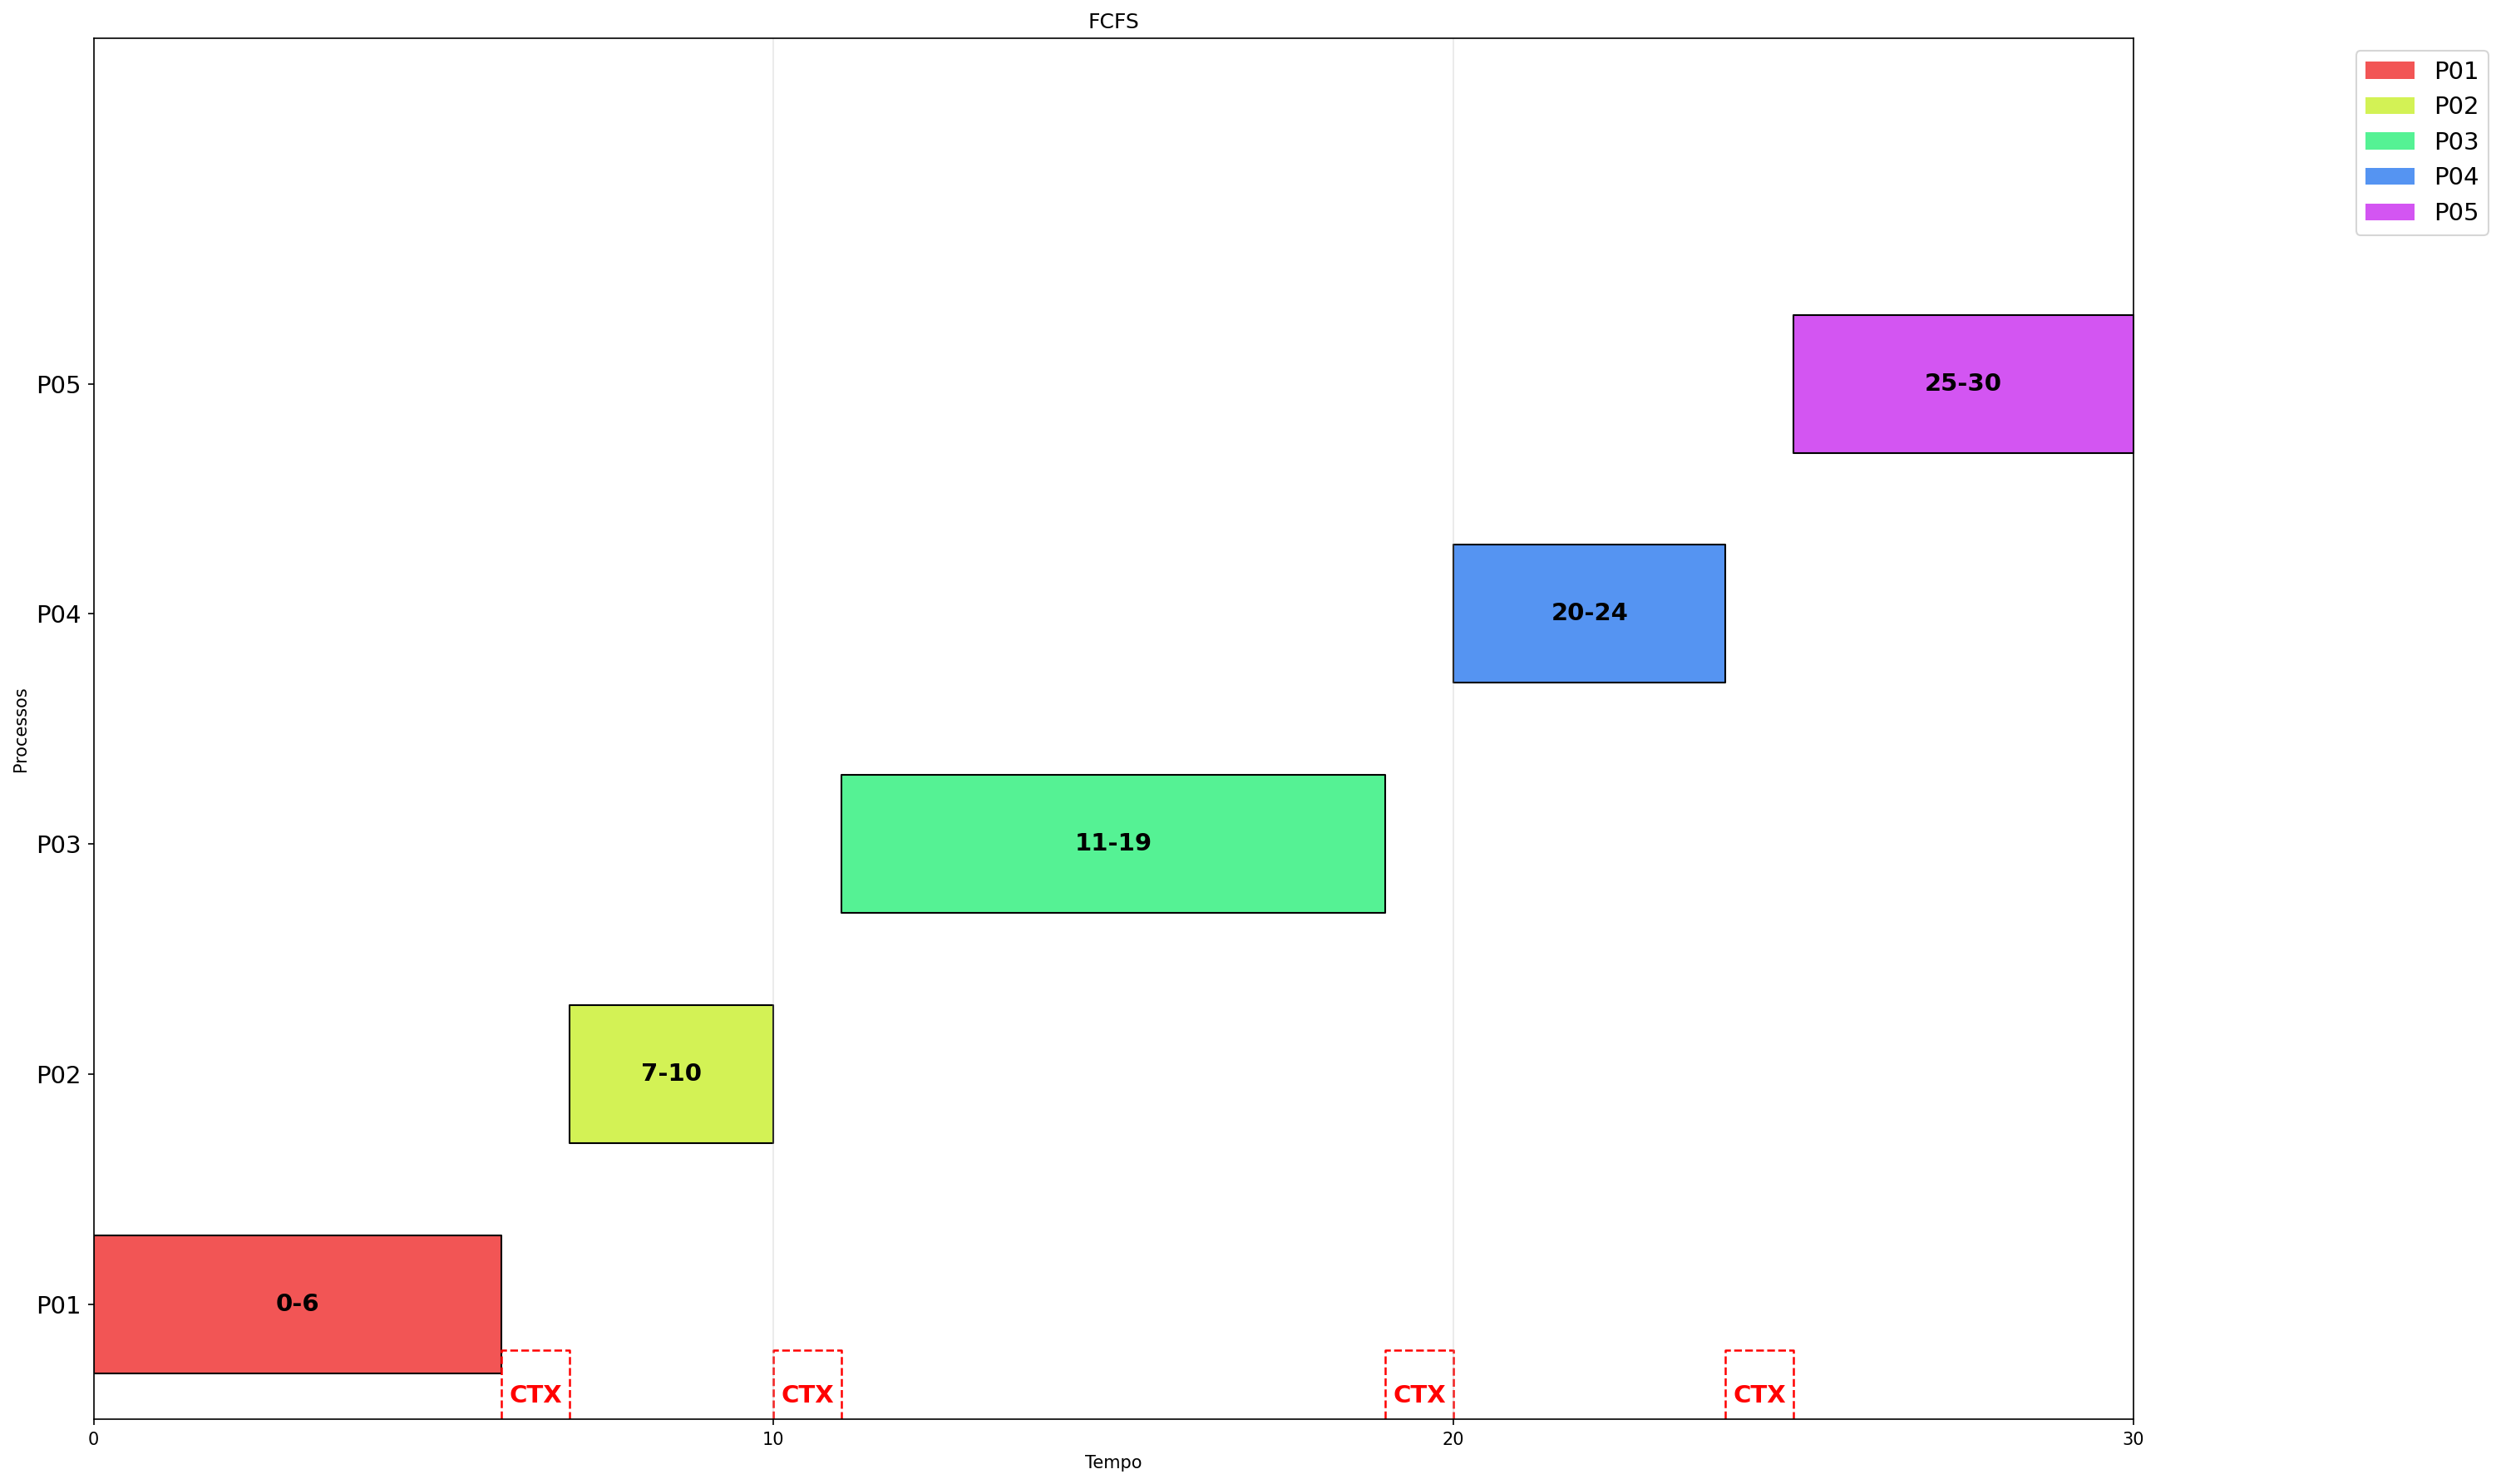

{'tempos_de_esperas': {'P01': 0, 'P02': 6, 'P03': 9, 'P04': 16, 'P05': 19},
 'tempos_de_retorno': {'P01': 6, 'P02': 9, 'P03': 17, 'P04': 20, 'P05': 24},
 'completados': 3,
 'log': [('P01', 0, 6),
         ('CTX', 6, 7),
         ('P02', 7, 10),
         ('CTX', 10, 11),
         ('P03', 11, 19),
         ('CTX', 19, 20),
         ('P04', 20, 24),
         ('CTX', 24, 25),
         ('P05', 25, 30)],
 'media_espera': 10,
 'desvio_espera': 7.648529270389178,
 'media_retorno': 15.2,
 'desvio_retorno': 7.52994023880668,
 'vazao': 0.15}

Executando SJF...


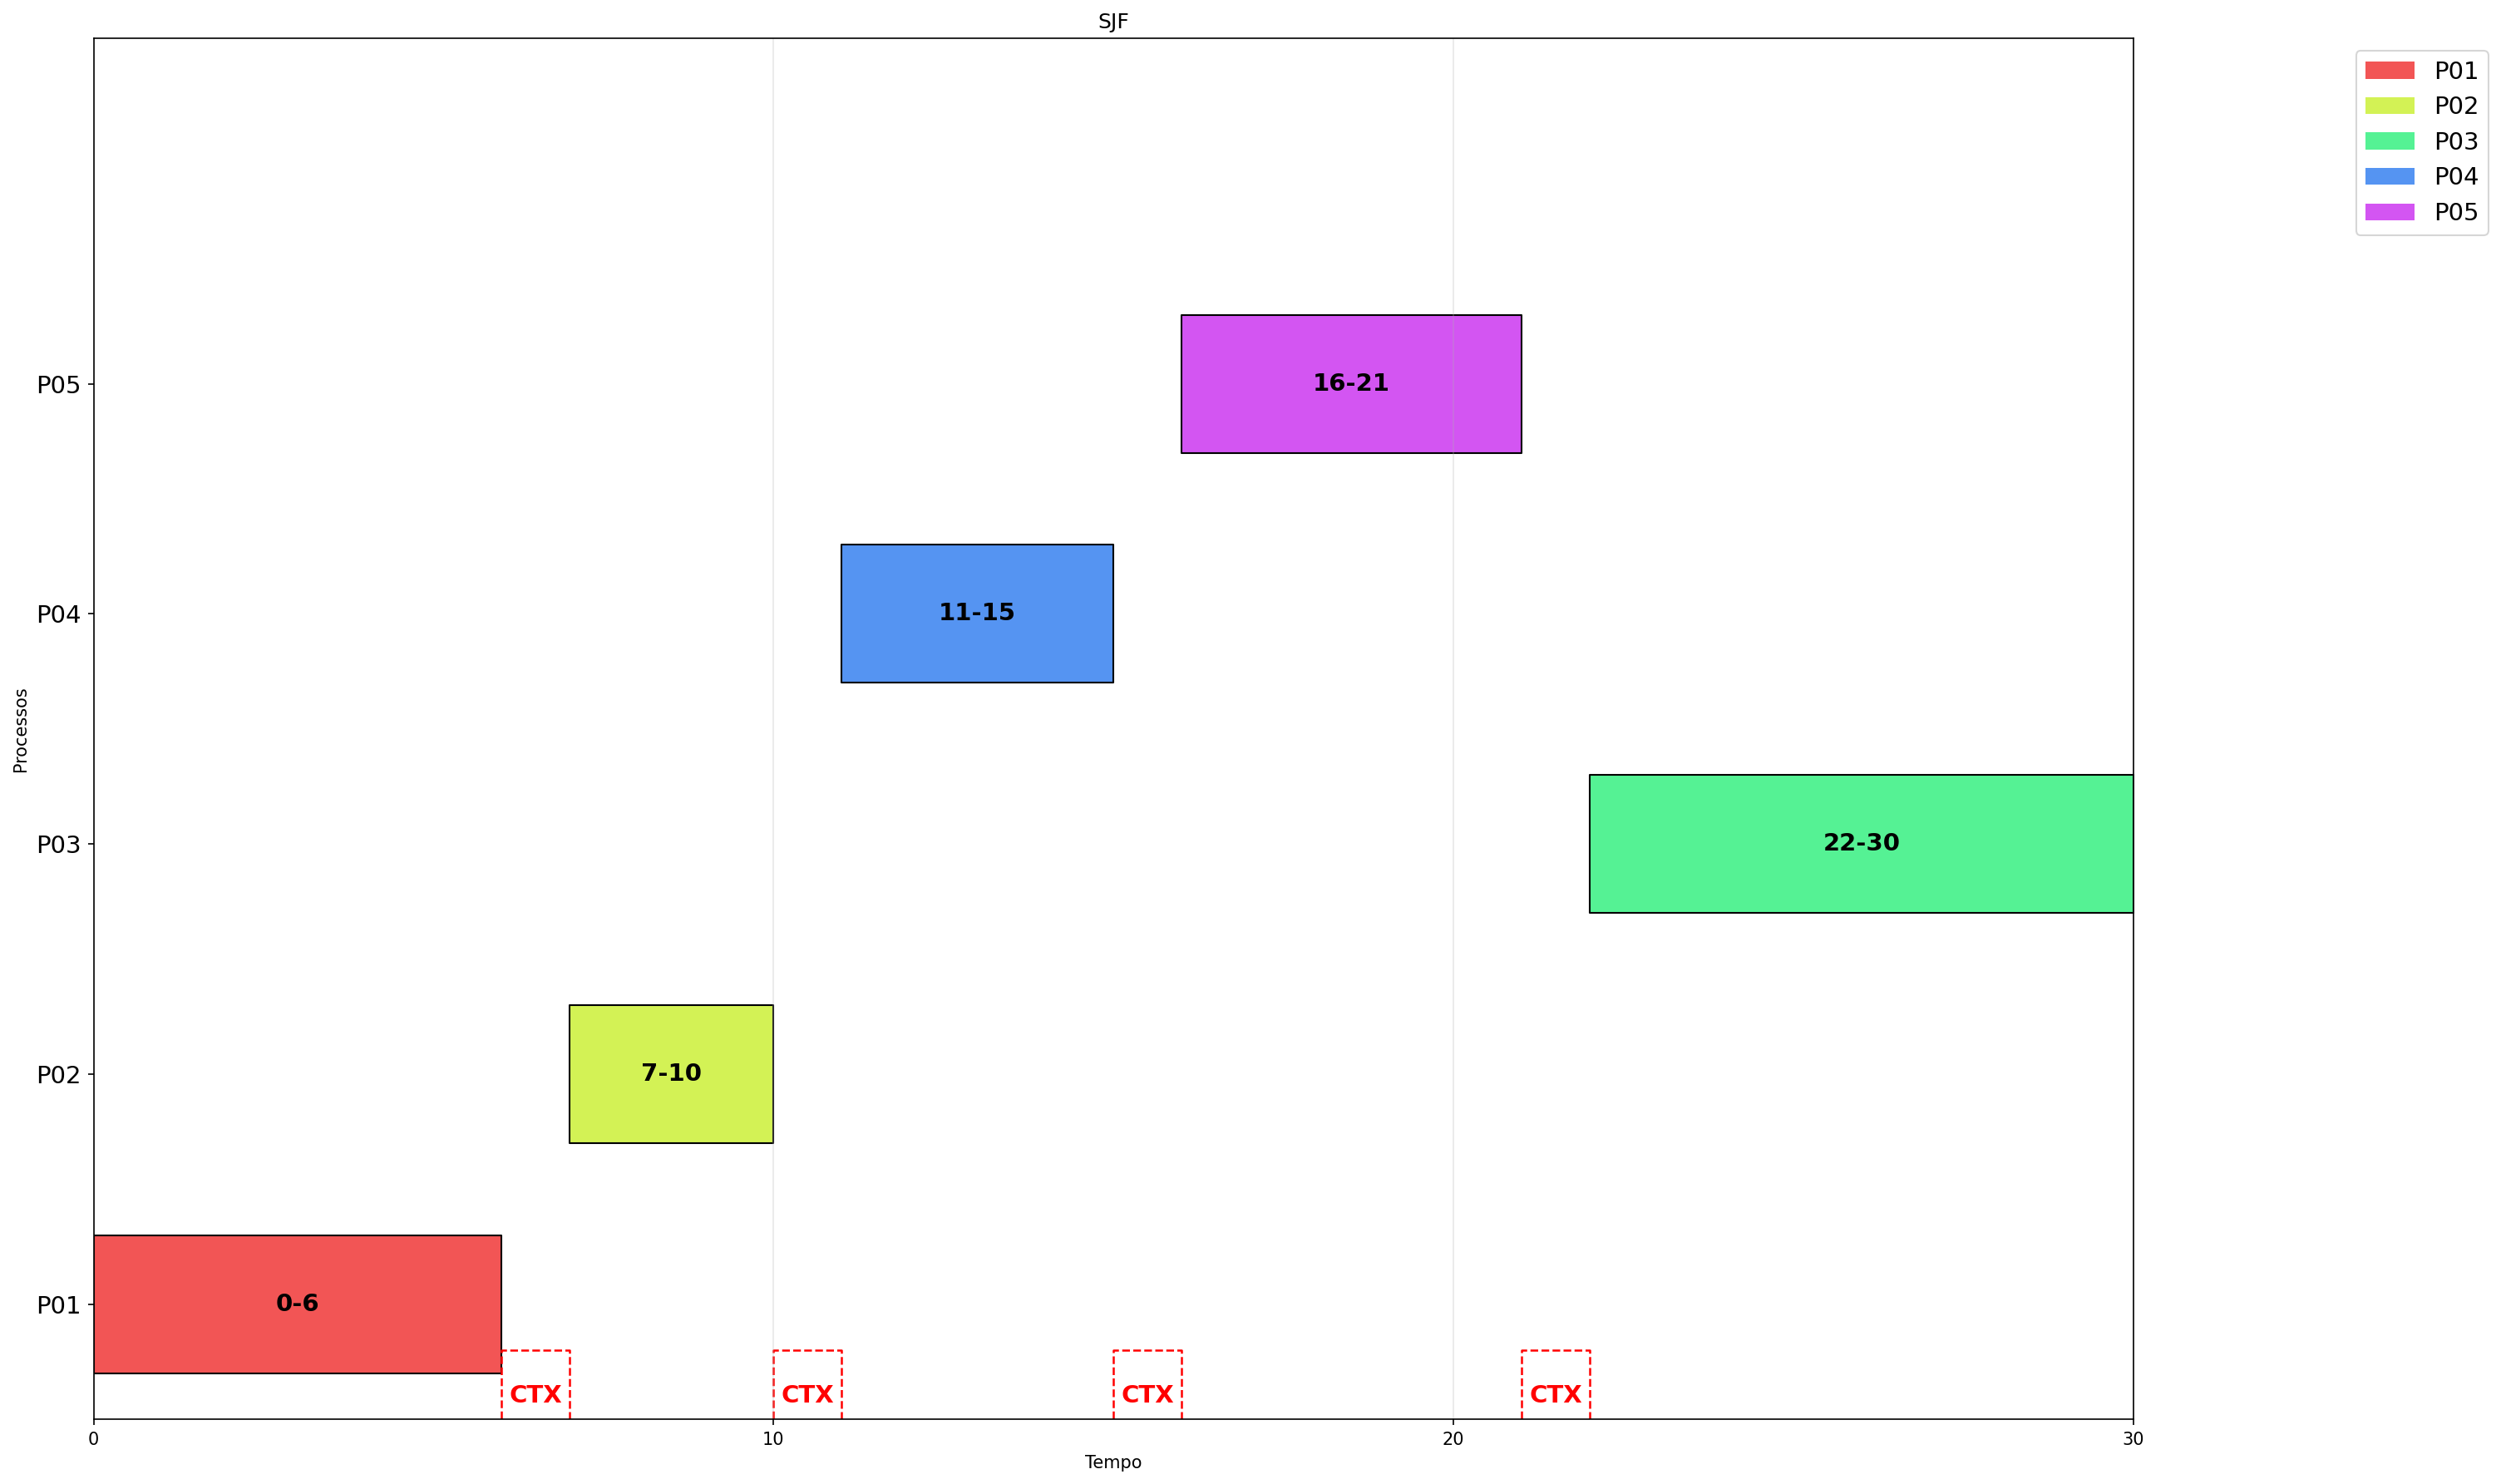

{'tempos_espera': {'P01': 0, 'P02': 6, 'P04': 7, 'P05': 10, 'P03': 20},
 'tempos_retorno': {'P01': 6, 'P02': 9, 'P04': 11, 'P05': 15, 'P03': 28},
 'completados': 3,
 'log': [('P01', 0, 6),
         ('CTX', 6, 7),
         ('P02', 7, 10),
         ('CTX', 10, 11),
         ('P04', 11, 15),
         ('CTX', 15, 16),
         ('P05', 16, 21),
         ('CTX', 21, 22),
         ('P03', 22, 30)],
 'media_espera': 8.6,
 'desvio_espera': 7.334848328356899,
 'media_retorno': 13.8,
 'desvio_retorno': 8.5848704125339,
 'vazao': 0.15}

Executando RR...
   Quantum: 2


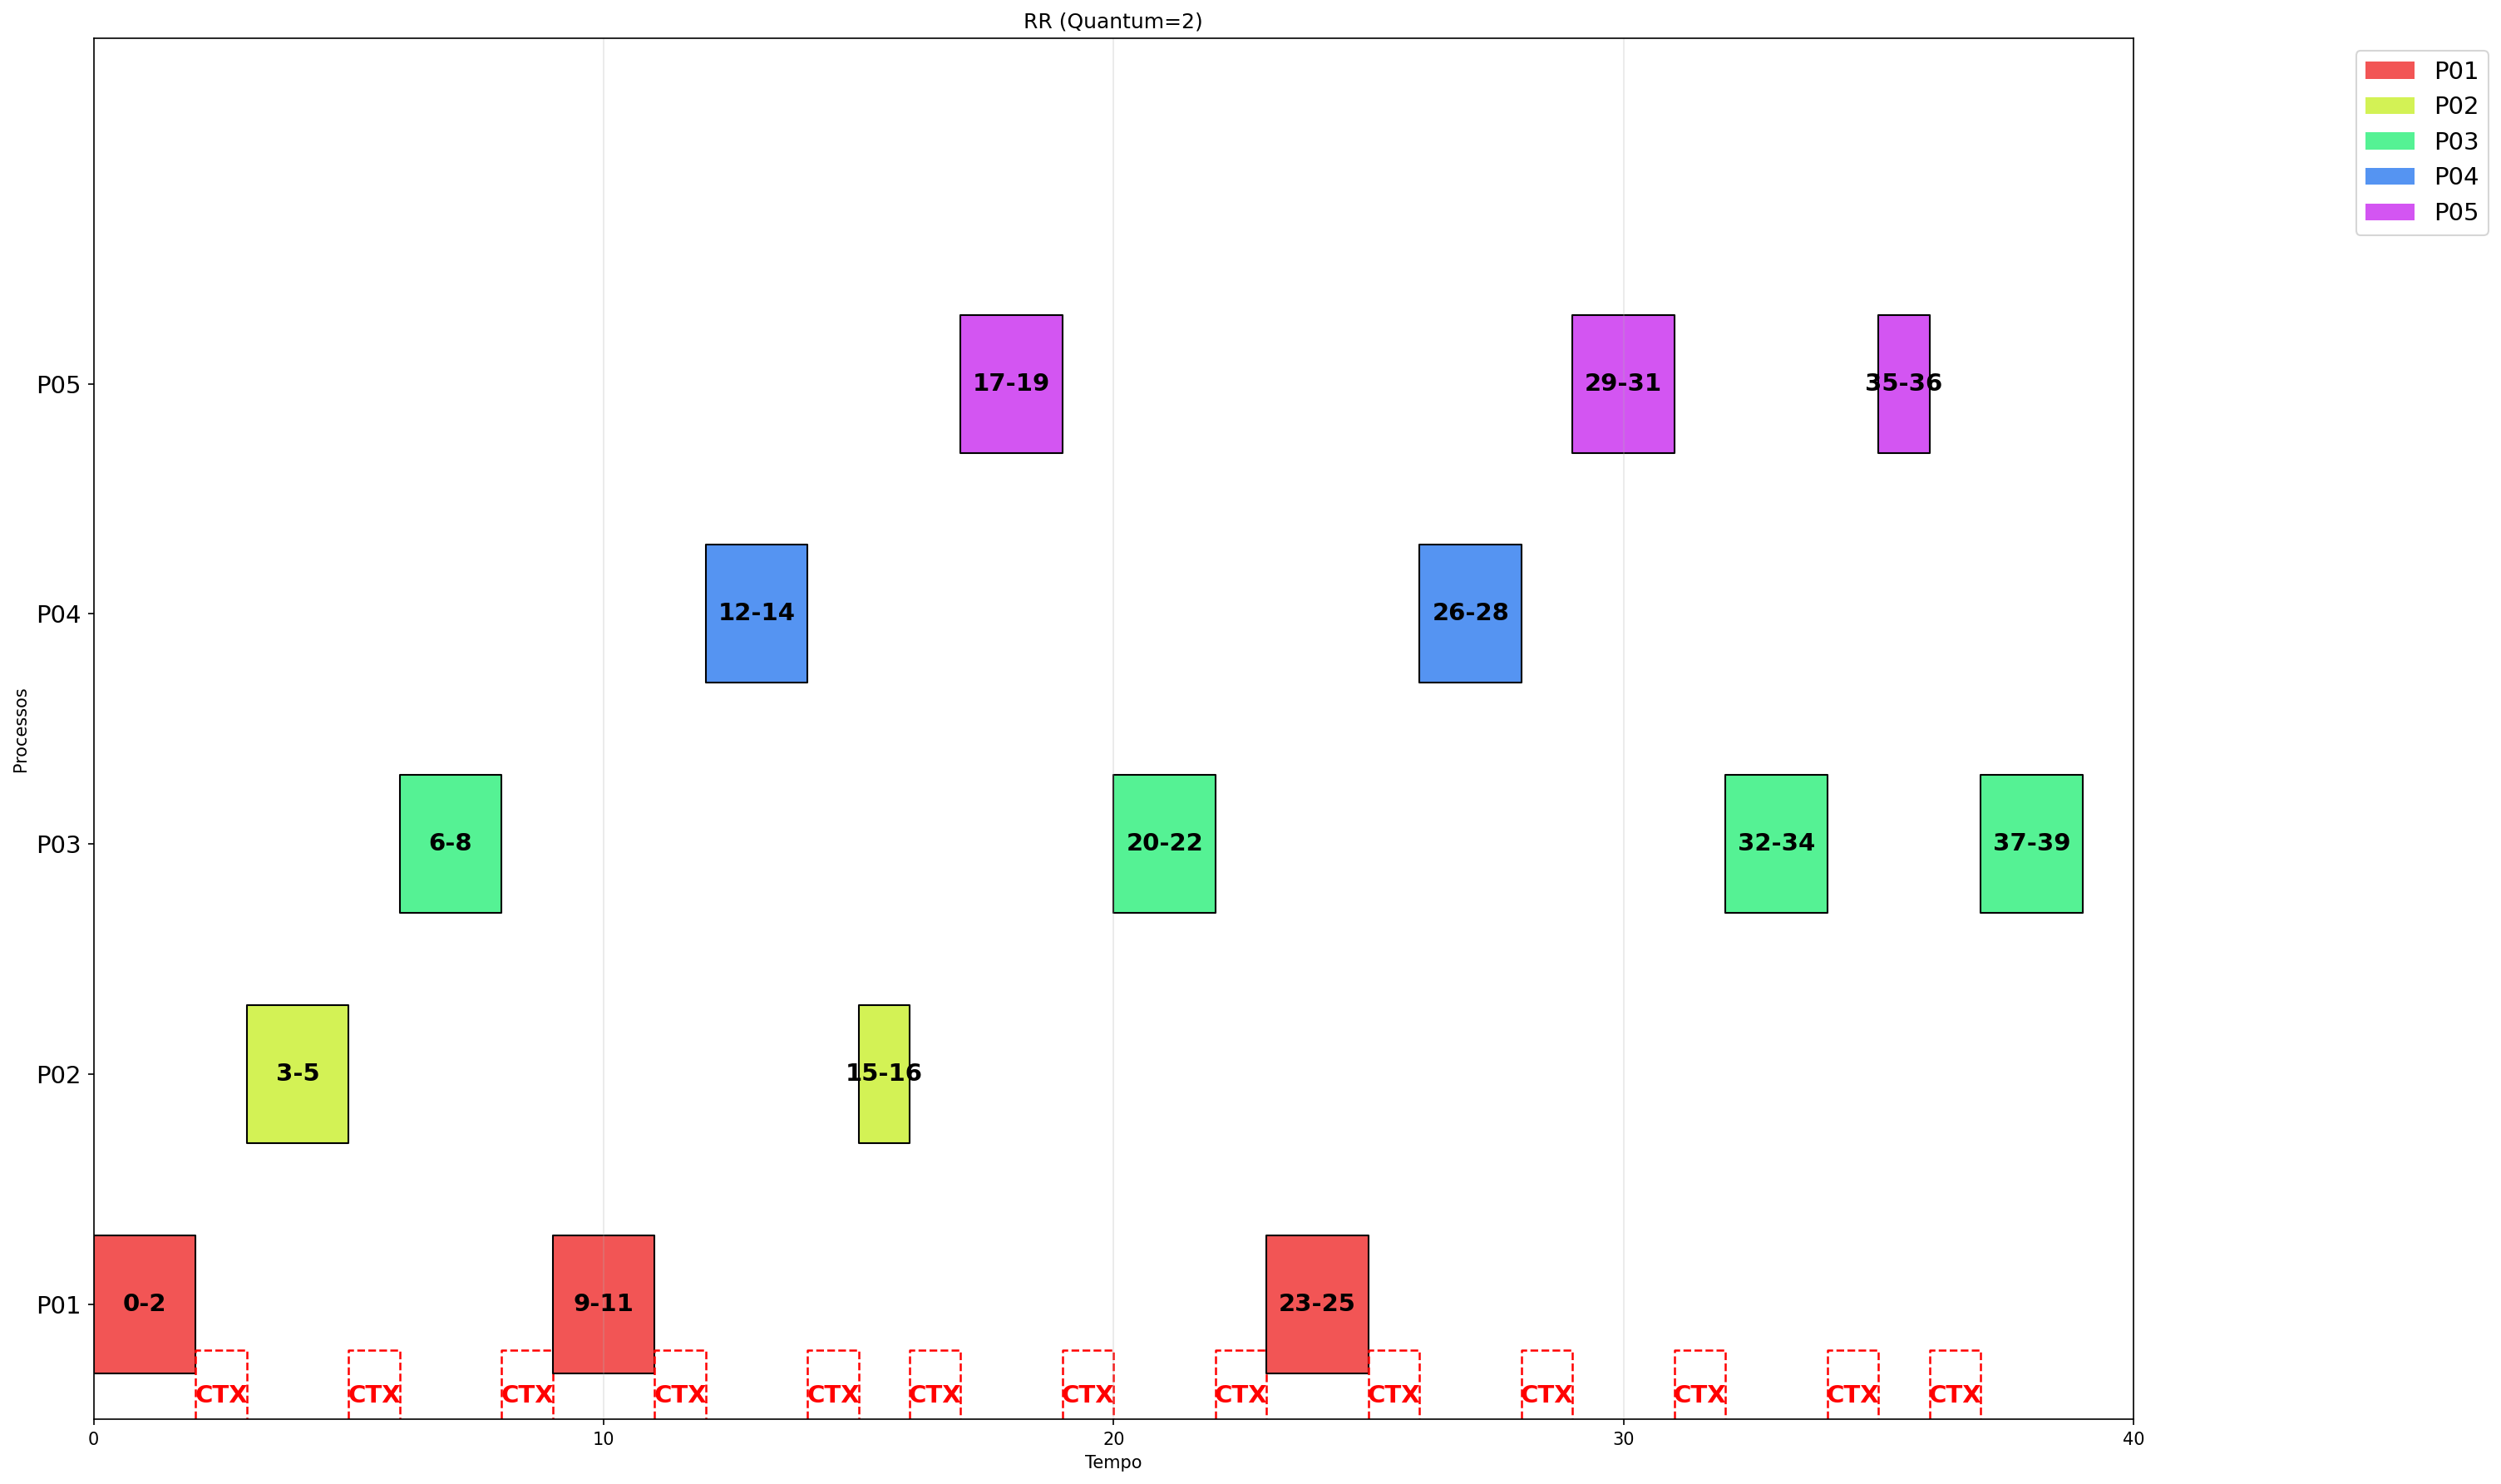

{'tempos_espera': {'P01': 19, 'P02': 12, 'P03': 29, 'P04': 20, 'P05': 25},
 'tempos_retorno': {'P01': 25, 'P02': 15, 'P03': 37, 'P04': 24, 'P05': 30},
 'completados': 1,
 'log': [('P01', 0, 2),
         ('CTX', 2, 3),
         ('P02', 3, 5),
         ('CTX', 5, 6),
         ('P03', 6, 8),
         ('CTX', 8, 9),
         ('P01', 9, 11),
         ('CTX', 11, 12),
         ('P04', 12, 14),
         ('CTX', 14, 15),
         ('P02', 15, 16),
         ('CTX', 16, 17),
         ('P05', 17, 19),
         ('CTX', 19, 20),
         ('P03', 20, 22),
         ('CTX', 22, 23),
         ('P01', 23, 25),
         ('CTX', 25, 26),
         ('P04', 26, 28),
         ('CTX', 28, 29),
         ('P05', 29, 31),
         ('CTX', 31, 32),
         ('P03', 32, 34),
         ('CTX', 34, 35),
         ('P05', 35, 36),
         ('CTX', 36, 37),
         ('P03', 37, 39)],
 'media_espera': 21,
 'desvio_espera': 6.442049363362563,
 'media_retorno': 26.2,
 'desvio_retorno': 8.105553651663778,
 'vazao': 0.05}
   Q

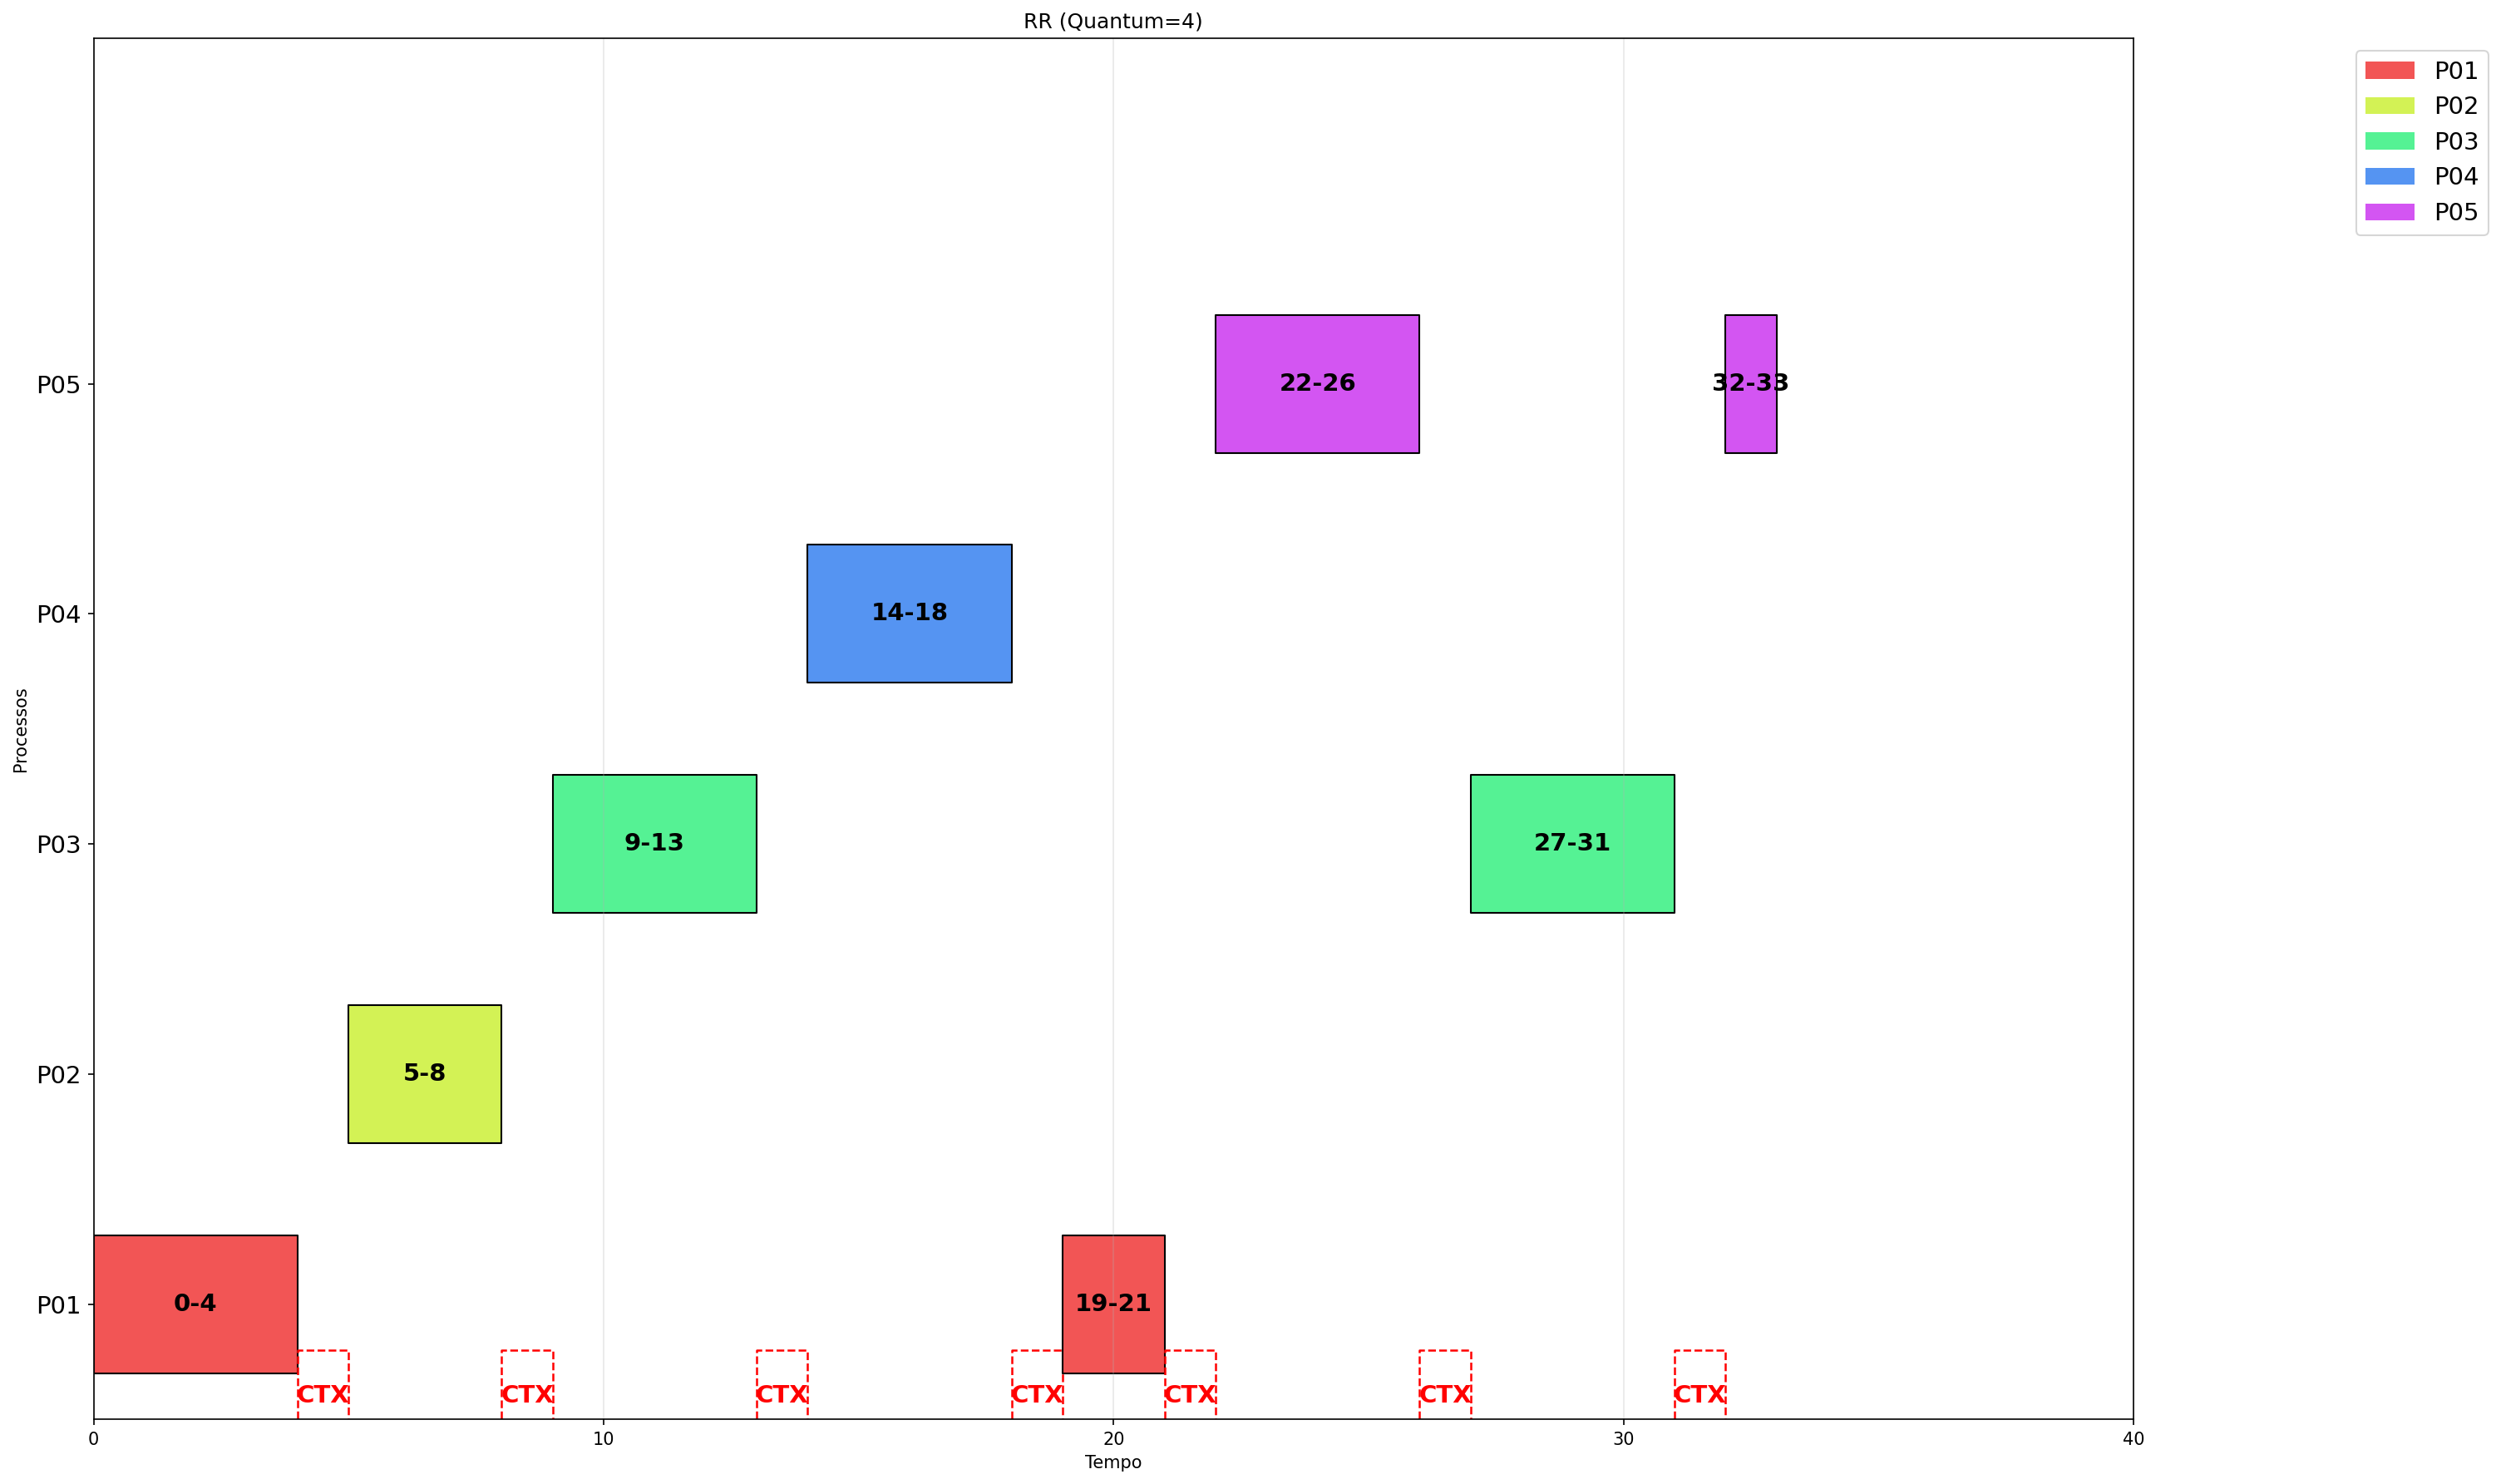

{'tempos_espera': {'P01': 15, 'P02': 4, 'P03': 21, 'P04': 10, 'P05': 22},
 'tempos_retorno': {'P01': 21, 'P02': 7, 'P03': 29, 'P04': 14, 'P05': 27},
 'completados': 2,
 'log': [('P01', 0, 4),
         ('CTX', 4, 5),
         ('P02', 5, 8),
         ('CTX', 8, 9),
         ('P03', 9, 13),
         ('CTX', 13, 14),
         ('P04', 14, 18),
         ('CTX', 18, 19),
         ('P01', 19, 21),
         ('CTX', 21, 22),
         ('P05', 22, 26),
         ('CTX', 26, 27),
         ('P03', 27, 31),
         ('CTX', 31, 32),
         ('P05', 32, 33)],
 'media_espera': 14.4,
 'desvio_espera': 7.569676347110225,
 'media_retorno': 19.6,
 'desvio_retorno': 9.154233993076646,
 'vazao': 0.1}
   Quantum: 8


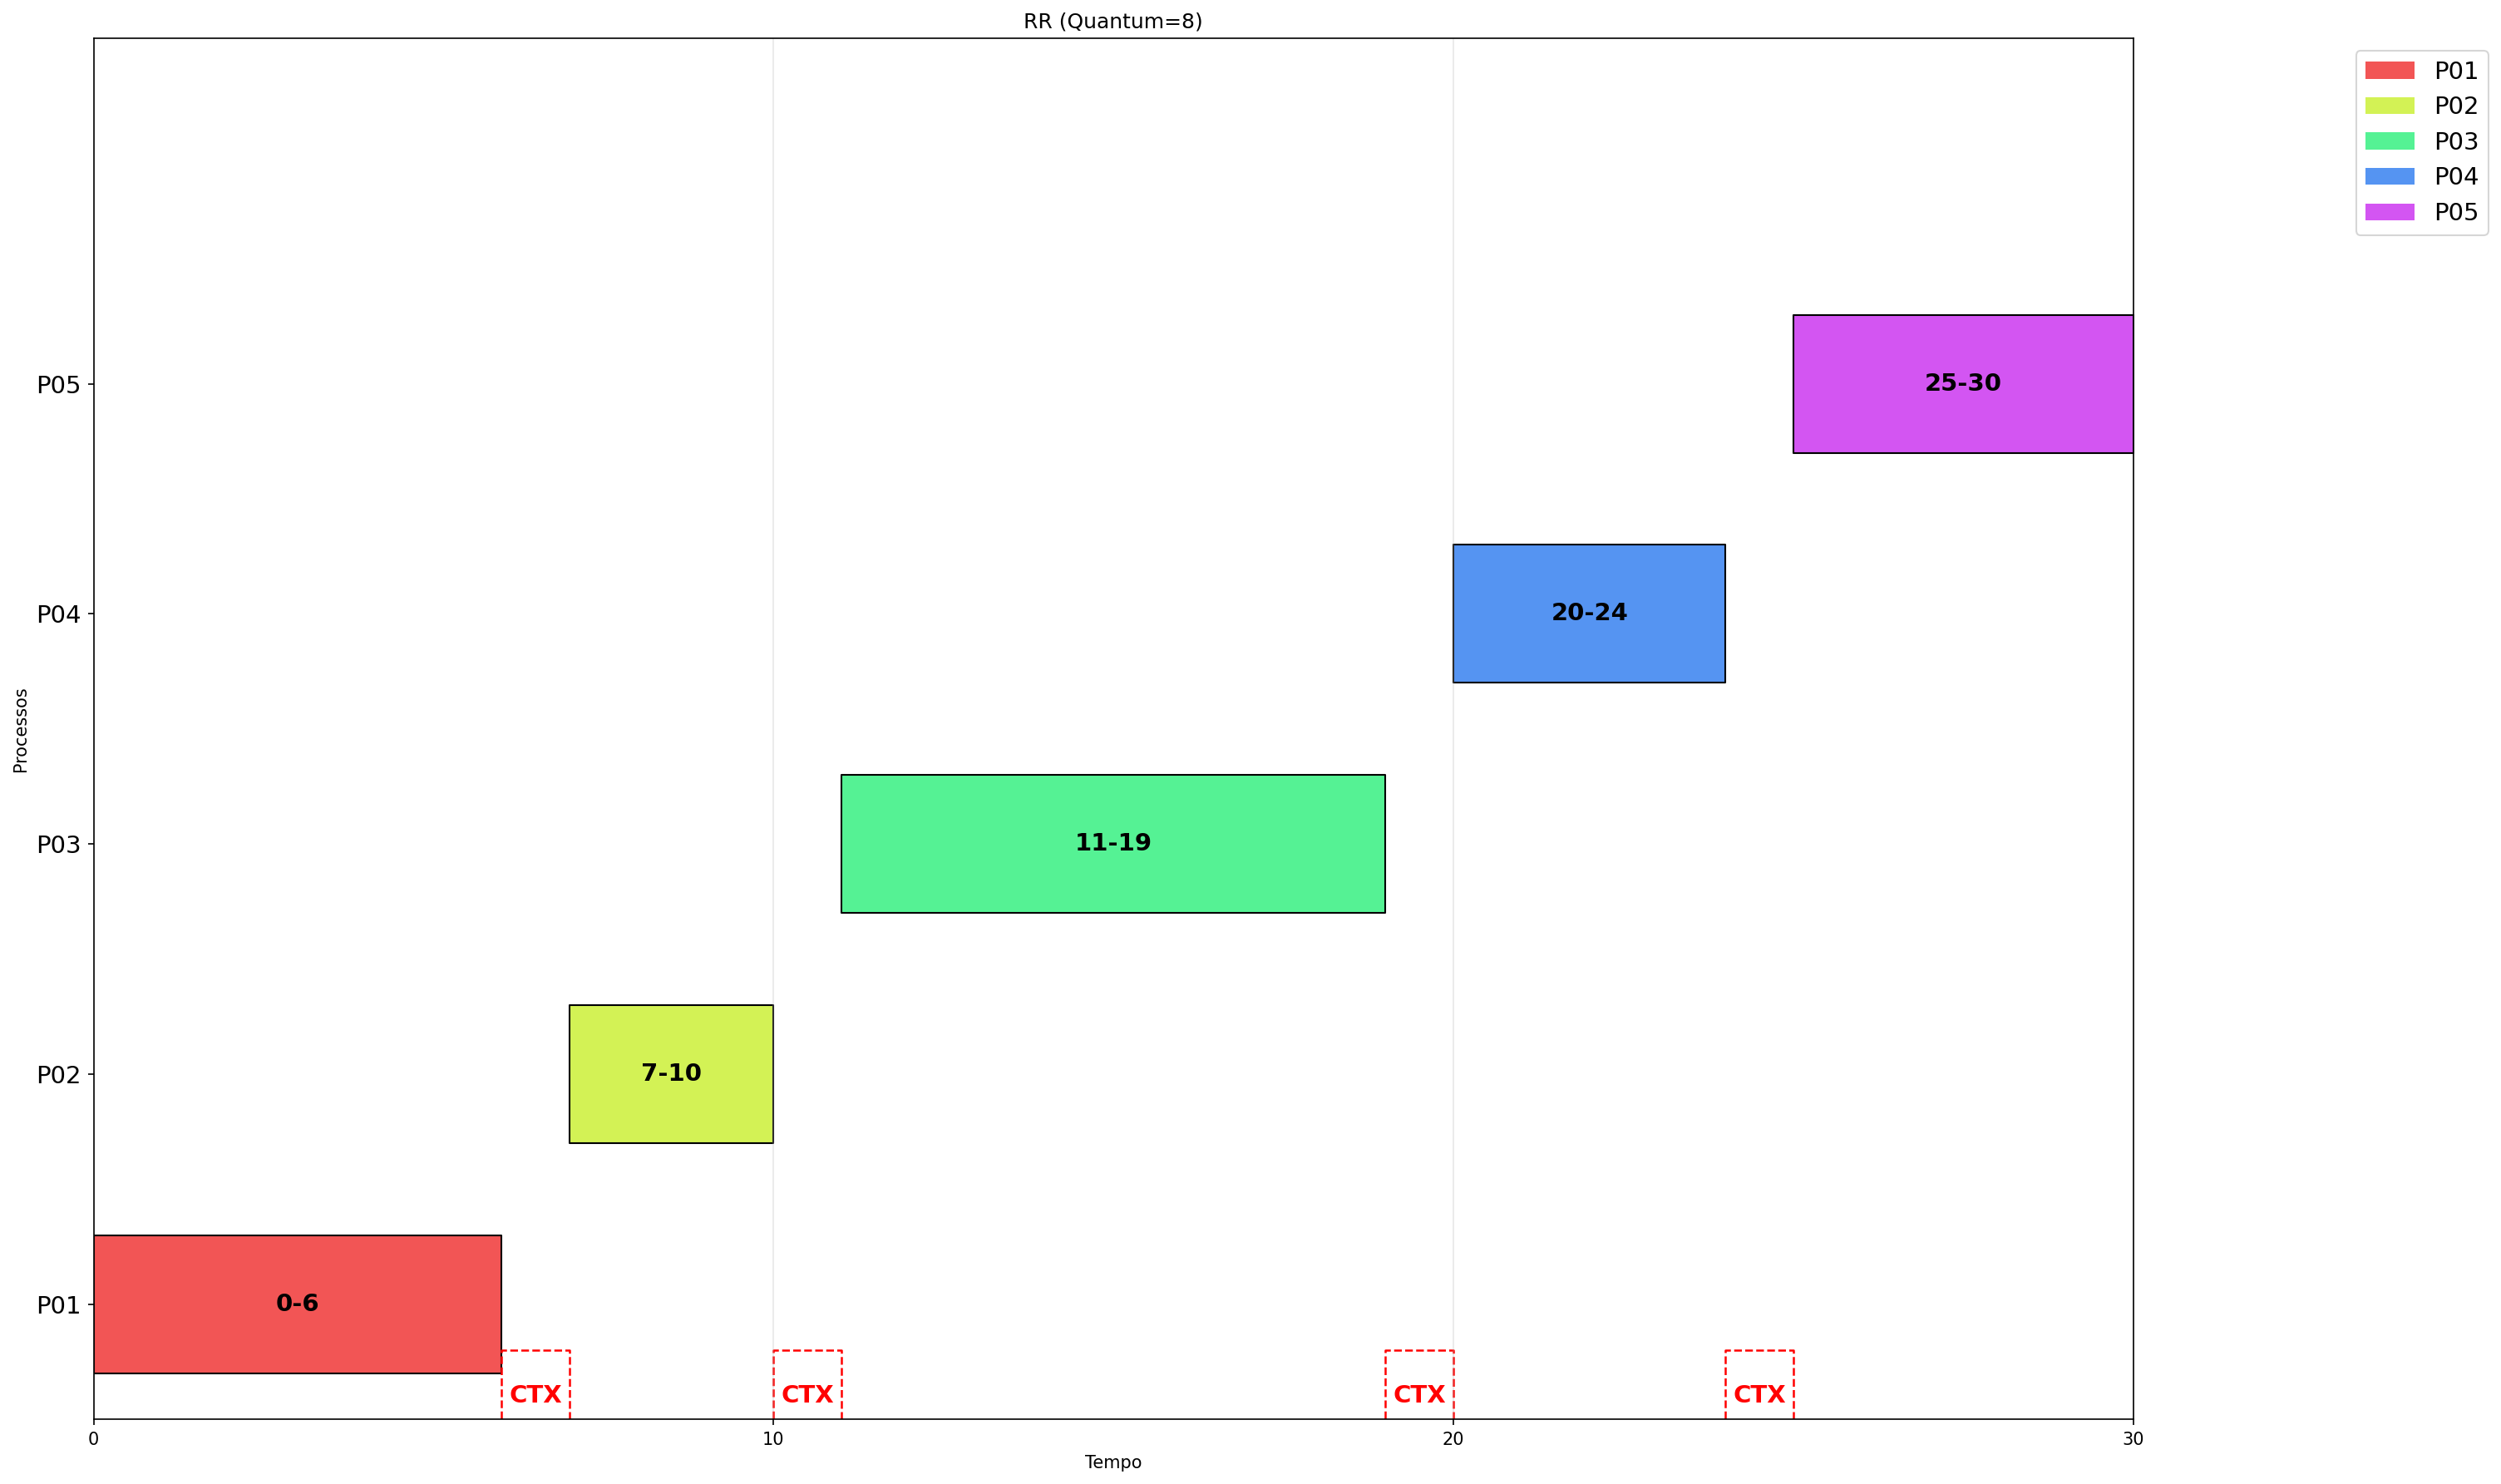

{'tempos_espera': {'P01': 0, 'P02': 6, 'P03': 9, 'P04': 16, 'P05': 19},
 'tempos_retorno': {'P01': 6, 'P02': 9, 'P03': 17, 'P04': 20, 'P05': 24},
 'completados': 3,
 'log': [('P01', 0, 6),
         ('CTX', 6, 7),
         ('P02', 7, 10),
         ('CTX', 10, 11),
         ('P03', 11, 19),
         ('CTX', 19, 20),
         ('P04', 20, 24),
         ('CTX', 24, 25),
         ('P05', 25, 30)],
 'media_espera': 10,
 'desvio_espera': 7.648529270389178,
 'media_retorno': 15.2,
 'desvio_retorno': 7.52994023880668,
 'vazao': 0.15}

COMPARAÇÃO ENTRE ALGORITMOS

FCFS:
   - Desvio Espera: 7.65
   - Média Espera: 10.00
   - Desvio Retorno: 7.53
   - Média Retorno: 15.20
   - Vazão: 0.150

SJF:
   - Desvio Espera: 7.33
   - Média Espera: 8.60
   - Desvio Retorno: 8.58
   - Média Retorno: 13.80
   - Vazão: 0.150

ROUND ROBIN:
   Quantum 2:
     - Desvio Espera: 6.44
     - Média Espera: 21.00
     - Desvio Retorno: 8.11
     - Média Retorno: 26.20
     - Vazão: 0.050
   Quantum 4:
     - Desvio Esp

In [10]:
def executar_algoritmos_do_json(data_dict):
    """Executa os algoritmos especificados no JSON"""

    # Extrair dados
    context_switch_cost = data_dict['metadata']['context_switch_cost']
    throughput_window_T = data_dict['metadata']['throughput_window_T']
    algorithms = data_dict['metadata']['algorithms']
    rr_quantums = data_dict['metadata'].get('rr_quantums', [1])
    processes = data_dict['workload']['processes']

    colors = gerar_cores(processes)
    resultados = {}

    for algoritmo in algorithms:
        print(f"\nExecutando {algoritmo}...")

        try:
            if algoritmo.upper() == "FCFS":
                resultados["FCFS"] = fcfs(
                    processos=processes,
                    custo_contexto=context_switch_cost,
                    T=throughput_window_T
                )
                show_fcfs(resultados["FCFS"], colors)
                pprint.pp(resultados["FCFS"])
            elif algoritmo.upper() == "SJF":
                resultados["SJF"] = sjf_nao_preemptivo(
                    processos=processes,
                    custo_contexto=context_switch_cost,
                    T=throughput_window_T
                )
                show_sjf(resultados["SJF"], context_switch_cost, processes, colors)
                pprint.pp(resultados["SJF"])
            elif algoritmo.upper() == "RR":
                resultados_rr = {}
                for quantum in rr_quantums:
                    print(f"   Quantum: {quantum}")
                    resultados_rr[quantum] = round_robin(
                        processos=processes,
                        quantum=quantum,
                        custo_contexto=context_switch_cost,
                        T=throughput_window_T
                    )
                    show_round_robin(resultados_rr[quantum], quantum, colors)
                    pprint.pp(resultados_rr[quantum])
                resultados["RR"] = resultados_rr

            else:
                print(f"Algoritmo não reconhecido: {algoritmo}")

        except Exception as e:
            print(f"Erro ao executar {algoritmo}: {e}")

    return resultados

# Executar todos os algoritmos do JSON
resultados_finais = executar_algoritmos_do_json(data_dict)

# Exibir resultados comparativos
print(f"\n{'='*70}")
print("COMPARAÇÃO ENTRE ALGORITMOS")
print(f"{'='*70}")

for algoritmo, resultado in resultados_finais.items():
    if algoritmo == "RR":
        print(f"\nROUND ROBIN:")
        for quantum, res in resultado.items():
            print(f"   Quantum {quantum}:")
            print(f"     - Desvio Espera: {res.get('desvio_espera', 'N/A'):.2f}")
            print(f"     - Média Espera: {res.get('media_espera', 'N/A'):.2f}")
            print(f"     - Desvio Retorno: {res.get('desvio_retorno', 'N/A'):.2f}")
            print(f"     - Média Retorno: {res.get('media_retorno', 'N/A'):.2f}")
            print(f"     - Vazão: {res.get('vazao', 'N/A'):.3f}")
    else:
        print(f"\n{algoritmo}:")
        print(f"   - Desvio Espera: {resultado.get('desvio_espera', 'N/A'):.2f}")
        print(f"   - Média Espera: {resultado.get('media_espera', 'N/A'):.2f}")
        print(f"   - Desvio Retorno: {resultado.get('desvio_retorno', 'N/A'):.2f}")
        print(f"   - Média Retorno: {resultado.get('media_retorno', 'N/A'):.2f}")
        print(f"   - Vazão: {resultado.get('vazao', 'N/A'):.3f}")

## Comparação de tempo médio de espera e de retorno

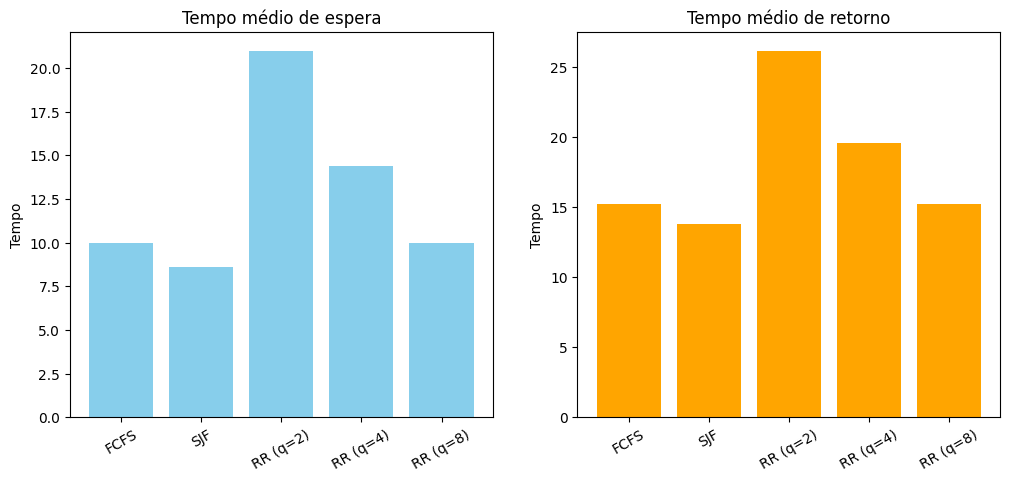

In [11]:
def plot_comparacao_medias(resultados):
    algs = []
    medias_espera = []
    medias_retorno = []

    for alg, res in resultados.items():
        if alg == "RR":
            for quantum, r in res.items():
                algs.append(f"RR (q={quantum})")
                medias_espera.append(r['media_espera'])
                medias_retorno.append(r['media_retorno'])
        else:
            algs.append(alg)
            medias_espera.append(res['media_espera'])
            medias_retorno.append(res['media_retorno'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].bar(algs, medias_espera, color="skyblue")
    ax[0].set_title("Tempo médio de espera")
    ax[0].set_ylabel("Tempo")
    ax[0].tick_params(axis='x', rotation=30)

    ax[1].bar(algs, medias_retorno, color="orange")
    ax[1].set_title("Tempo médio de retorno")
    ax[1].set_ylabel("Tempo")
    ax[1].tick_params(axis='x', rotation=30)

    plt.show()

plot_comparacao_medias(resultados_finais)

## Comparação de desvios padrões

/tmp/ipython-input-974546695.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dados, labels=labels, patch_artist=True)


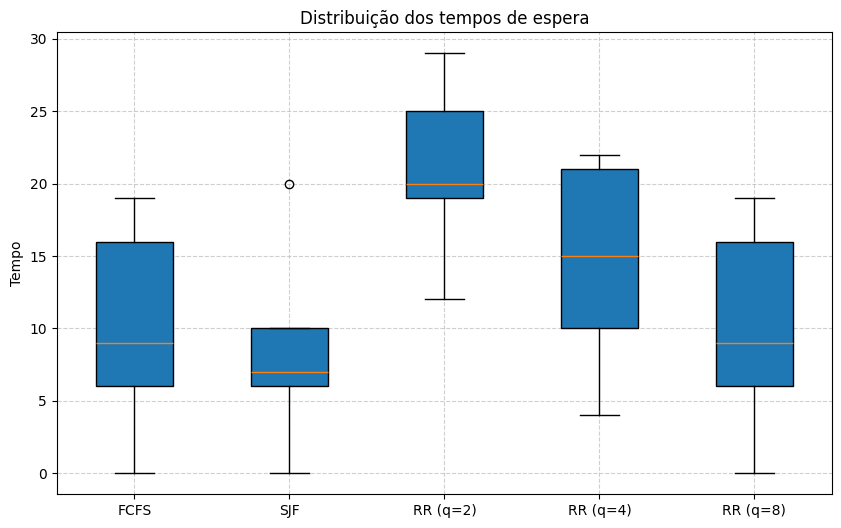

/tmp/ipython-input-974546695.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dados, labels=labels, patch_artist=True)


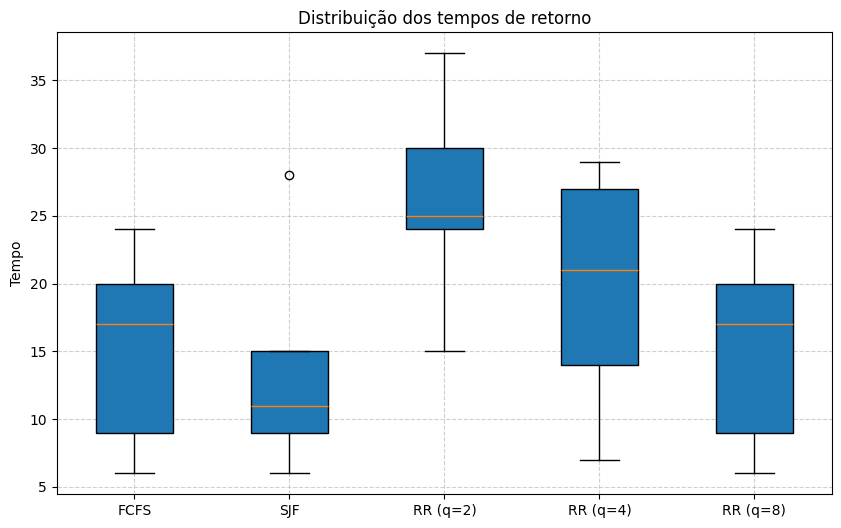

In [12]:
def boxplot_tempos(resultados, tipo="espera"):
    dados = []
    labels = []

    for alg, res in resultados.items():
        if alg == "RR":
            for q, r in res.items():
                if tipo == "espera":
                    tempos = list(r['tempos_espera'].values())
                else:
                    tempos = list(r['tempos_retorno'].values())
                dados.append(tempos)
                labels.append(f"RR (q={q})")
        else:
            if tipo == "espera":
                tempos = list(res['tempos_de_esperas'].values() if 'tempos_de_esperas' in res else res['tempos_espera'].values())
            else:
                tempos = list(res['tempos_de_retorno'].values() if 'tempos_de_retorno' in res else res['tempos_retorno'].values())
            dados.append(tempos)
            labels.append(alg)

    plt.figure(figsize=(10,6))
    plt.boxplot(dados, labels=labels, patch_artist=True)
    plt.title(f"Distribuição dos tempos de {tipo}")
    plt.ylabel("Tempo")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Usar assim:
boxplot_tempos(resultados_finais, tipo="espera")
boxplot_tempos(resultados_finais, tipo="retorno")

## Vazão

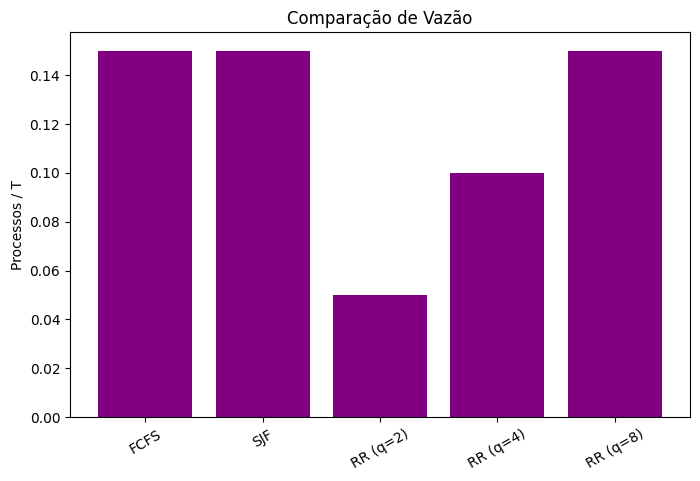

In [13]:
def plot_vazao(resultados):
    algs = []
    vazoes = []

    for alg, res in resultados.items():
        if alg == "RR":
            for quantum, r in res.items():
                algs.append(f"RR (q={quantum})")
                vazoes.append(r['vazao'])
        else:
            algs.append(alg)
            vazoes.append(res['vazao'])

    plt.figure(figsize=(8,5))
    plt.bar(algs, vazoes, color="purple")
    plt.title("Comparação de Vazão")
    plt.ylabel("Processos / T")
    plt.xticks(rotation=30)
    plt.show()

plot_vazao(resultados_finais)

## Impacto do Quantum

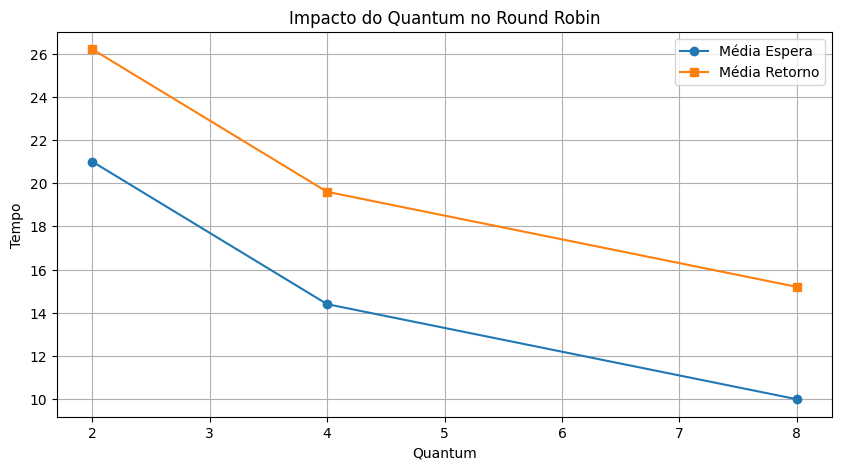

In [14]:
def plot_quantum_rr(resultados):
    if "RR" not in resultados:
        print("⚠️ Nenhum resultado de Round Robin disponível.")
        return

    quantums = []
    medias_espera = []
    medias_retorno = []

    for q, res in resultados["RR"].items():
        quantums.append(q)
        medias_espera.append(res['media_espera'])
        medias_retorno.append(res['media_retorno'])

    plt.figure(figsize=(10,5))
    plt.plot(quantums, medias_espera, marker="o", label="Média Espera")
    plt.plot(quantums, medias_retorno, marker="s", label="Média Retorno")
    plt.title("Impacto do Quantum no Round Robin")
    plt.xlabel("Quantum")
    plt.ylabel("Tempo")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_quantum_rr(resultados_finais)
